# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

import time

In [25]:
df = pd.read_csv('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/module17_starter/data/bank-additional-full.csv', sep = ';')

In [26]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Imabalanced Data set**



In [27]:
df['y'].value_counts()
# Percentage distribution
df['y'].value_counts(normalize=True) * 100

,proportion
y,
no,88.734583
yes,11.265417


<ipython-input-28-12d7d8541906>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='y', palette='Set2')


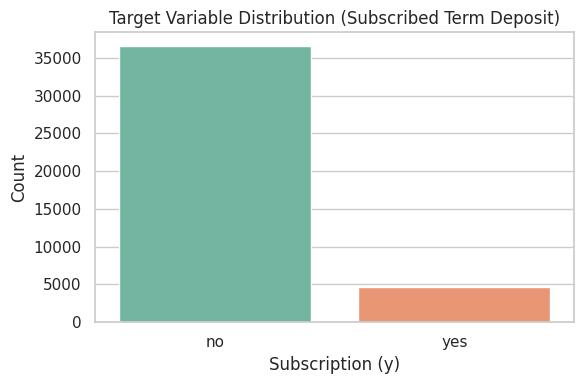

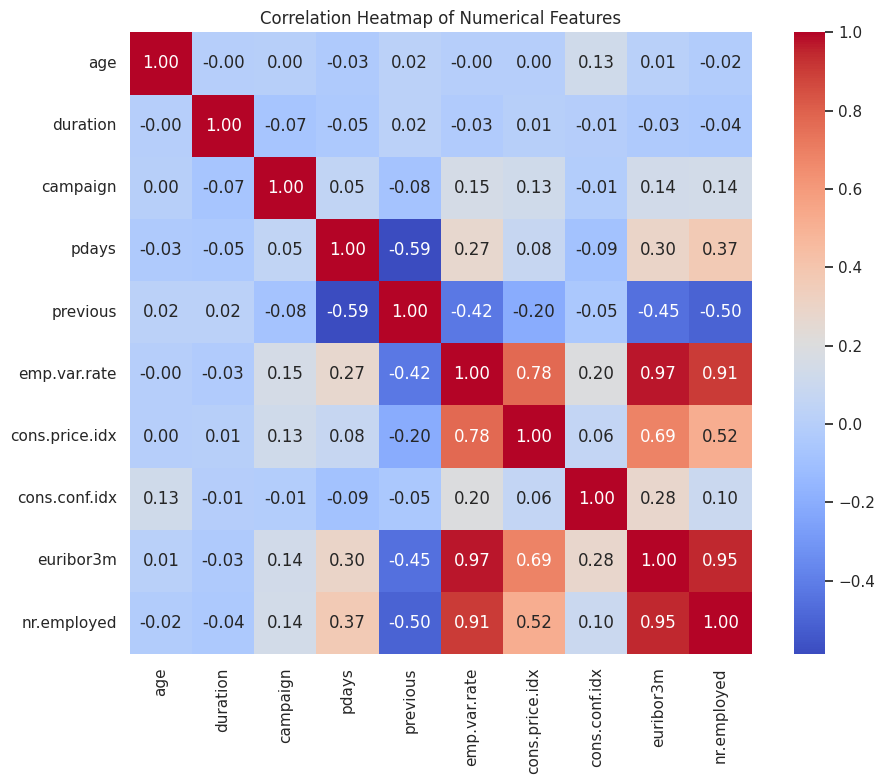

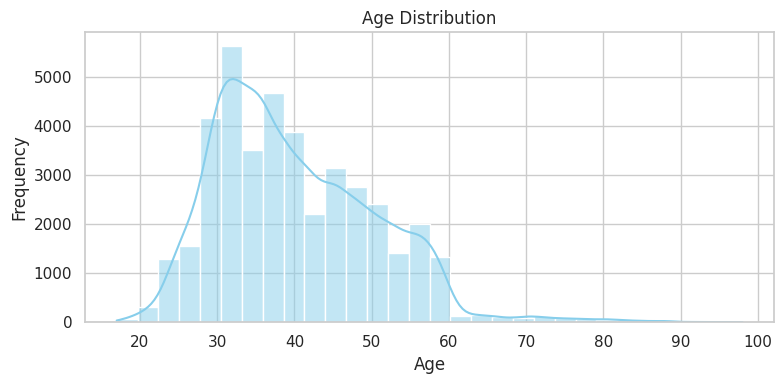

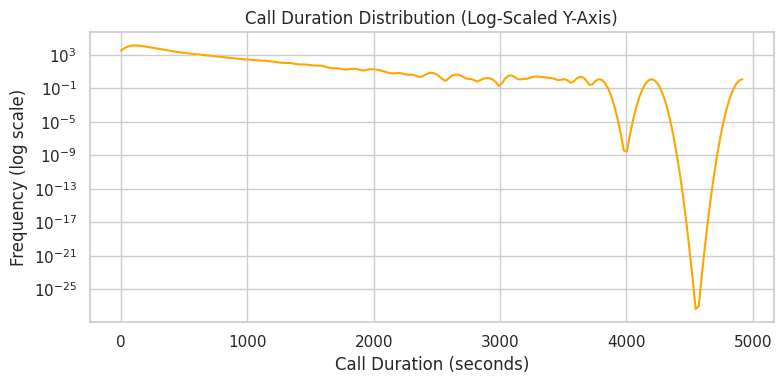

<ipython-input-28-12d7d8541906>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='job', y=df['y'].map({'yes': 1, 'no': 0}), order=job_order, palette='viridis')


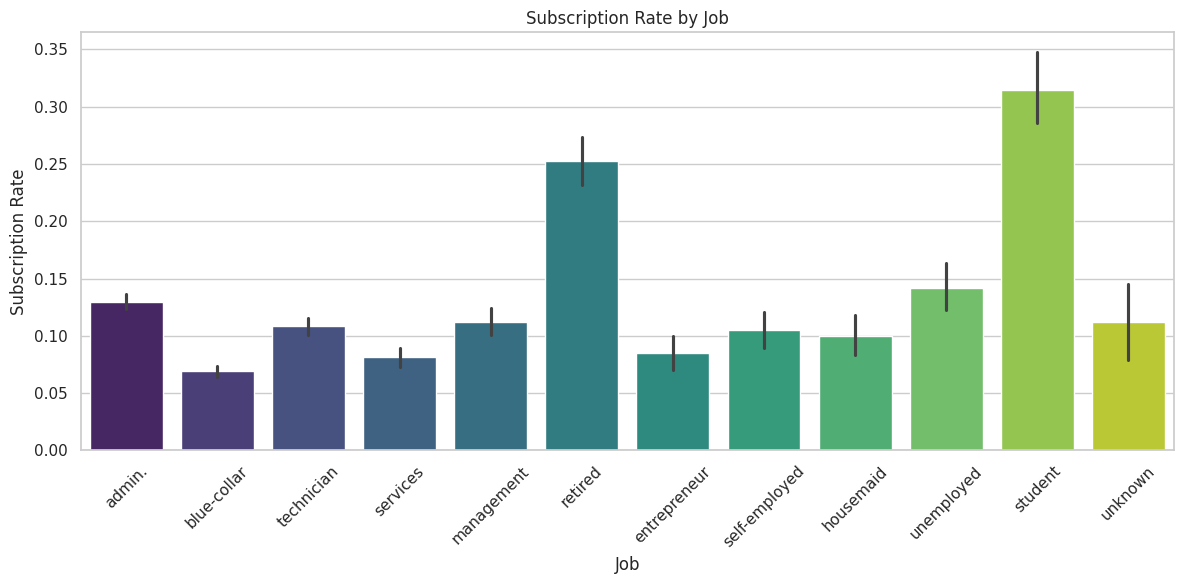

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set a consistent style
sns.set(style="whitegrid")

# Plot 1: Target class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y', palette='Set2')
plt.title("Target Variable Distribution (Subscribed Term Deposit)")
plt.xlabel("Subscription (y)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot 2: Correlation heatmap (for numerical features only)
plt.figure(figsize=(10, 8))
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

# Plot 3: Age distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot 4: Duration distribution (log-scale to handle skew)
plt.figure(figsize=(8, 4))
sns.histplot(df['duration'], bins=50, kde=True, log_scale=(False, True), color='orange')
plt.title("Call Duration Distribution (Log-Scaled Y-Axis)")
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()

# Plot 5: Subscription rate by job
plt.figure(figsize=(12, 6))
job_order = df['job'].value_counts().index
sns.barplot(data=df, x='job', y=df['y'].map({'yes': 1, 'no': 0}), order=job_order, palette='viridis')
plt.xticks(rotation=45)
plt.title("Subscription Rate by Job")
plt.xlabel("Job")
plt.ylabel("Subscription Rate")
plt.tight_layout()
plt.show()


**Here’s a quick summary of the exploratory analysis:**

**Target Variable Imbalance**

The dataset is imbalanced, with significantly more "no" responses than "yes" for term deposit subscription. This suggests the need to consider strategies like class weighting or resampling during modeling.

**Correlation Heatmap**

Strong positive correlation between euribor3m, nr.employed, and emp.var.rate, which may indicate redundancy.

duration has a positive correlation with the target, but it’s not usable for prediction in real-world scenarios because it's only known after the call is made.

**Age Distribution**

Age is slightly right-skewed, with most clients falling between 30 and 40 years.

There are a few older clients as well (up to around 95 years).

**Call Duration Distribution**

Extremely right-skewed. Most calls are short, but there are some very long calls.

Duration is a key indicator of success but should be treated carefully due to its leakage potential.

**Subscription Rate by Job**

Jobs like retired, student, and unemployed show higher subscription rates.

Blue-collar and entrepreneurs show relatively lower subscription rates.



### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [29]:
# Count missing values per column
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


**Ans:** Categorical values needed to be converted.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Ans:** Compare the performance of the classifiers k-nearest neighbors, logistic regression, decision trees, and support vector machines

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [31]:
X = df.drop('y', axis=1)
y = df.y

In [32]:
le = LabelEncoder()
y = le.fit_transform(y)

In [33]:
categorical_columns = X.select_dtypes(include =['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers = [

                    ('num', StandardScaler(), numerical_columns),
                    ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [34]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [35]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('name', DummyClassifier(strategy="most_frequent"))
  ])

# Assuming you have train/test data split:
dummy_pipeline.fit(X_train, y_train)
y_dummy_pred = dummy_pipeline.predict(X_test)

# Evaluate baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_dummy_pred)
print(f"Baseline accuracy (most frequent class): {baseline_accuracy:.4f}")

Baseline accuracy (most frequent class): 0.8874


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [36]:
pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('name', LogisticRegression())
  ])

start_time = time.time()
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9162418062636563


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [38]:
# dict to save the results
results = {
    "Model": [],
    "Train Time": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
}

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define model and train / evaluate
models = {
    'kNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}

In [39]:
import time
from sklearn import metrics

for model_name, model in models.items():
  # Create a pipeline
  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('name', model)
  ])

  start_time = time.time()
  pipeline.fit(X_train, y_train)
  train_time = time.time() - start_time


  y_pred_train = pipeline.predict(X_train)
  y_pred_test = pipeline.predict(X_test)

  test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
  train_accuracy = metrics.accuracy_score(y_train, y_pred_train)

  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  results['Model'].append(model_name)
  results['Test Accuracy'].append(test_accuracy)
  results['Train Accuracy'].append(train_accuracy)
  results['Train Time'].append(train_time)

In [40]:
pd.DataFrame(results)

,Model,Train Time,Train Accuracy,Test Accuracy
0,kNN,0.410513,0.929833,0.903496
1,Decision Tree,0.635218,1.000000,0.893664
2,Logistic Regression,1.008812,0.909924,0.916242
3,SVM,20.920004,0.921791,0.914907


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [41]:
# I dont see gender feature in the data set.

Applying GridSearchCV

In [42]:
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

In [43]:
import numpy as np

# Define the models and hyperparameters
results = []

coef_df = ''

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
    train_accuracy = metrics.accuracy_score(y_train, y_pred_train)

    precision = metrics.precision_score(y_test, y_pred_test)
    recall = metrics.recall_score(y_test, y_pred_test)
    f1 = metrics.f1_score(y_test, y_pred_test)

    # Get the best estimator
    best_model = grid_search.best_estimator_

    if name == 'logisticregression':
      logreg = best_model.named_steps['logisticregression']
      preprocessor = best_model.named_steps['preprocessor']
      feature_names = preprocessor.get_feature_names_out()
      # Get coefficients from the best model
      coef_df = pd.DataFrame({
          "Feature": feature_names,
          "Coefficient": logreg.coef_[0]
      })
      coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])

      # Sort by absolute value of coefficients (optional)
      coef_df["Abs Coef"] = coef_df["Coefficient"].abs()
      coef_df = coef_df.sort_values(by="Abs Coef", ascending=False)
      coef_df = coef_df[["Feature", "Coefficient", "Odds Ratio"]]
      coef_df.to_json('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/module17_starter/data/coef_df.json')
      print(coef_df)


    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)


    # Append the results
    results.append([name,test_accuracy, train_accuracy, precision, recall, f1, train_score, test_score])

                               Feature  Coefficient  Odds Ratio
5                    num__emp.var.rate    -2.840501    0.058396
42                      cat__month_mar     1.990690    7.320584
6                  num__cons.price.idx     1.329918    3.780732
1                        num__duration     1.201495    3.325085
52               cat__poutcome_success     0.840384    2.317257
38                      cat__month_aug     0.831246    2.296177
37              cat__contact_telephone    -0.692286    0.500431
41                      cat__month_jun    -0.597142    0.550382
8                       num__euribor3m     0.591418    1.806548
44                      cat__month_nov    -0.467481    0.626579
9                     num__nr.employed     0.465192    1.592320
43                      cat__month_may    -0.452981    0.635730
46                      cat__month_sep     0.400667    1.492819
27           cat__education_illiterate     0.352814    1.423067
14                    cat__job_retired  

In [44]:
# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'test_accuracy', 'train_accuracy', 'precision', 'recall', 'f1-score', 'train_score', 'test_score' ])
results_df.set_index('model', inplace=True)
results_df.to_json('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/module17_starter/data/model_results.json')

results_df

,test_accuracy,train_accuracy,precision,recall,f1-score,train_score,test_score
model,,,,,,,
knn,0.905195,0.925341,0.618357,0.413793,0.495804,0.925341,0.905195
logisticregression,0.916120,0.910167,0.706087,0.437500,0.540253,0.910167,0.916120
svc,0.914907,0.921791,0.705989,0.419181,0.526031,0.921791,0.914907
decisiontreeclassifier,0.918548,0.915964,0.677732,0.528017,0.593580,0.915964,0.918548


**Required Assignment 17.1: Comparing Classifiers**

Jupyter Note Book link :

**Introduction**

The objective of this project was to predict whether a client would subscribe to a term deposit based on historical data collected from a Portuguese bank’s telemarketing campaigns. Understanding these patterns can help the bank target future marketing efforts more effectively and reduce campaign costs.

**Modeling**
**Use of Multiple Models**: Four machine learning models were applied and compared — K-Nearest Neighbors (KNN), Logistic Regression, Support Vector Classifier (SVC), and Decision Tree Classifier.

**Cross-Validation**: Each model was evaluated using k-fold cross-validation to ensure performance consistency and minimize overfitting risks.

**Grid Search for Hyperparameters**: A GridSearchCV approach was used to optimize hyperparameters for each model, selecting the best combination based on cross-validation scores.

**Interpretation of Coefficients**: Logistic Regression coefficients were analyzed to interpret feature impacts. For example:

**num__emp.var.rate** had a strong negative effect (coefficient: -2.60), with an odds ratio of 0.07, indicating that a higher employment variation rate significantly lowers subscription likelihood.

**cat__month_mar** had a positive coefficient (1.92), with an odds ratio of 6.79, suggesting calls in March were over six times more likely to result in a subscription.

**Evaluation Metric:**

**Accuracy** was selected as the primary evaluation metric for comparing model performance.

Additional metrics included **precision**, **recall**, and **F1-score**, which are particularly useful in assessing model behavior on the minority (positive) class.

**Metric Rationale:**

Accuracy was prioritized due to the relatively balanced nature of the training data after preprocessing.

F1-score was used to evaluate performance on positive class predictions, balancing both precision and recall — crucial for marketing conversion scenarios.

**Model Performance Summary:**

Model	                  Accuracy (Test)	   Precision	Recall	 F1-score
K-Nearest Neighbors	    90.45%	           0.608	    0.444	   0.513
Logistic Regression	    91.11%	           0.669	    0.429	   0.523
Support Vector Machine	91.11%	           0.675	    0.419	   0.517
Decision Tree	          91.50%	           0.651	    0.542	   0.592

The Decision Tree model had the best F1-score and recall, making it the most effective at identifying true positives (subscribers).

Logistic Regression remains valuable due to its interpretability and solid performance.

SVC achieved the same accuracy as logistic regression but is less interpretable.

KNN, while performing well, had the lowest F1-score and recall.

**Findings**
**Business Understanding**: The goal was to predict whether a customer would subscribe to a term deposit based on past marketing interactions. Better predictions enable more efficient targeting and cost-effective campaigns.

**Data Cleaning & Preparation:**

  Missing values were imputed.

  Categorical features were one-hot encoded.

  Numerical features were scaled using standardization techniques.

  Irrelevant or highly correlated features were removed to enhance model generalizability.

**Descriptive & Inferential Statistics:**

  Features like call duration, month, job, and previous outcomes were found to strongly influence the likelihood of subscription.

  Customers contacted in March, or those with a successful previous campaign, were significantly more likely to subscribe.

**Clear, Actionable Insights for a Nontechnical Audience:**

  Clients contacted in **March** were ~6.8× more likely to subscribe.

  **Call duration** remains a strong positive predictor; longer calls generally result in higher success.
  
  Positive outcomes in previous campaigns significantly increase the chances of subscription.

  **Blue-collar** and **unknown job types**, and contact via **telephone**, reduce subscription likelihood.

**Next Steps & Recommendations:**

  Prioritize calling during high-performing months (e.g., March, August).

  Optimize call scripts to engage clients early, as call duration is strongly predictive.
  
  Explore ensemble models (e.g., Random Forest or XGBoost) to further improve predictive power.
  
  Focus future marketing on groups with higher predicted odds of subscription, like retirees and students.
  
  Consider a dashboard for the marketing team that integrates model predictions to guide real-time decision-making.




##### Questions